In [1]:
#First things first, this is all the data the project needs, this is run in google colab(free version)
def get_datasets():
  import json
  json_object = json.dumps({"username":"milenstanev","key":"b7cdda665e3939e2b406dc5ff07edb4f"})
  with open("kaggle.json", "w") as outfile:
    outfile.write(json_object)
  ! pip install -q kaggle
  ! mkdir ~/.kaggle 
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download -d theblackmamba31/landscape-image-colorization
  !unzip landscape-image-colorization.zip;

In [2]:
get_datasets();

Streaming output truncated to the last 5000 lines.
  inflating: landscape Images/gray/2914.jpg  
  inflating: landscape Images/gray/2915.jpg  
  inflating: landscape Images/gray/2916.jpg  
  inflating: landscape Images/gray/2917.jpg  
  inflating: landscape Images/gray/2918.jpg  
  inflating: landscape Images/gray/2919.jpg  
  inflating: landscape Images/gray/292.jpg  
  inflating: landscape Images/gray/2920.jpg  
  inflating: landscape Images/gray/2921.jpg  
  inflating: landscape Images/gray/2922.jpg  
  inflating: landscape Images/gray/2923.jpg  
  inflating: landscape Images/gray/2924.jpg  
  inflating: landscape Images/gray/2925.jpg  
  inflating: landscape Images/gray/2926.jpg  
  inflating: landscape Images/gray/2927.jpg  
  inflating: landscape Images/gray/2928.jpg  
  inflating: landscape Images/gray/2929.jpg  
  inflating: landscape Images/gray/293.jpg  
  inflating: landscape Images/gray/2930.jpg  
  inflating: landscape Images/gray/2931.jpg  
  inflating: landscape Images/g

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim
from torchvision.datasets import Flickr8k
from torchvision.utils import save_image
import urllib
import torchvision.transforms
import torchvision
import torchvision.datasets 
from torchvision import transforms
from torchvision.transforms import transforms
import torchvision.models as models
from torchvision.models import vgg19
import PIL

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

<center><img src="pictures/pix2pix/pix2pix_title.png" height=500; width=500><center>

<center>https://openaccess.thecvf.com/content_cvpr_2017/papers/Isola_Image-To-Image_Translation_With_CVPR_2017_paper.pdf <center> link to paper

<center>
    <img src="pictures/pix2pix/generator.png" height=500; width=500> 
<center>

**This is the generator that we'll be using. It's not quite the one that I've coded, but it'll do the work at least visually. It's a unet(the names comes from the u-shaped shape that layers create). It's a general model, that's why the picture that is shown here is a different kind of generator. It can do 'Day to night', 'Edges to photo' and so on**.

**The generator is encoder-decoder. I will split it into two classes**.</br>
<center><img src="pictures/pix2pix/encoder.png" height=300; width=300;><center>

In [5]:
class Generator_encoder(nn.Module):#Inheriting from nn.Module - we can override the forward method
    def __init__(self, in_channels, out_channels, batch_norm, stride):
        super(Generator_encoder, self).__init__()

        self.batch_norm = batch_norm #Bool for batch_norm
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(4,4), stride=stride, padding=1)
        #Initializing the heavy lifter in the model
        
        self.batch_norm_layer = nn.BatchNorm2d(out_channels) if self.batch_norm is True else nn.Identity()
        #Again, as I did earlier, if batch_norm is False we just skip to the next layer
        
        self.leaky_relu = nn.LeakyReLU(0.2)
        #The variation of the ReLU with a little big negative slope
    
    def forward(self, x):#Here x is a Black/White picture
        return self.leaky_relu(self.batch_norm_layer(self.conv(x)))

**Continuing with the decoder block part of the generator** </br>
<center><img src="pictures/pix2pix/decoder.png" height=300; width=300;><center>

**The special layer here is the transposed convolution. It takes an image, runs a kernel through it and returns a upscaled image. It's a different approach than the PixelShuffle, but a very often used one. One the gif below we have a 4x4 image, kernel with size 3x3 and it upscaled from 4x4 to 6x6** </br>
<center><img src="https://miro.medium.com/v2/resize:fit:1400/1*kOThnLR8Fge_AJcHrkR3dg.gif" height=300; width=300;><center>

In [6]:
class Generator_decoder(nn.Module):
    def __init__(self, in_channels, out_channels, dropout):
        super(Generator_decoder, self).__init__()

        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(4,4), stride=2, padding=1)
        #Again initializing the heavy lifters, but this time is a little bit different.
        
        self.leaky_relu = nn.ReLU()
        #Again, maybe the most used activation function(in hidden layers at least)
        
        self.dropout = dropout
        self.dropout_layer = nn.Dropout2d(dropout) if self.dropout is True else nn.Identity()
        #Same as the cell above, if dropout is False -> use Identity
        
        self.batch_norm_layer = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):#x is the information comming from the bottleneck
        return self.leaky_relu(self.batch_norm_layer(self.dropout_layer(self.conv(x))))

**This is the whole generator architecture. I had many problems with shapes mismatches, channels mismatches and yes, everything that could go wrong went wrong, that's why it looks so manually typed.** </br>
- **I'm currently not using the upper cell, if I have enough time, I will change it**

In [7]:
class Generator(nn.Module):
    def __init__(self, in_channels):
        super(Generator, self).__init__()
        
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
        
        
        self.first_enc = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.LeakyReLU(0.2)
        )
        
        self.second_enc = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(4,4), stride=(2,2), padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.third_enc = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(4,4), stride=(2,2), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )
        
        self.fourth_enc = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(4,4), stride=(2,2), padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        self.fifth_enc = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(4,4), stride=(2,2), padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        self.sixth_enc = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(4,4), stride=(2,2), padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        self.seventh_enc = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(4,4), stride=(2,2), padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        self.eighth_enc = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(4,4), stride=(2,2), padding=(1,1)),
            nn.ReLU()
        )
        
        self.first_dec = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.second_dec = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.third_dec = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.fourth_dec = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        self.fifth_dec = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        self.sixth_dec = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.seventh_dec = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        #Well a lot of initialization, a lot of typing, but I was kind of desperate things thing to work, so..

    def forward(self, x):
        
        out_1 = self.first_enc(x)
        out_2 = self.second_enc(out_1)
        out_3 = self.third_enc(out_2)
        out_4 = self.fourth_enc(out_3)
        out_5 = self.fifth_enc(out_4)
        out_6 = self.sixth_enc(out_5)
        out_7 = self.seventh_enc(out_6)
        bottle_neck = self.eighth_enc(out_7)

        out_1_dec = self.first_dec(bottle_neck)
        out_2_dec = self.second_dec(torch.cat([out_1_dec, out_7], dim=1))#Skip connection
        out_3_dec = self.third_dec(torch.cat([out_2_dec, out_6], dim=1))#Skip connection
        out_4_dec = self.fourth_dec(torch.cat([out_3_dec, out_5], dim=1))#Skip connection
        out_5_dec = self.fifth_dec(torch.cat([out_4_dec, out_4], dim=1))#Skip connection
        out_6_dec = self.sixth_dec(torch.cat([out_5_dec, out_3], dim=1))#Skip connection
        out_7_dec = self.seventh_dec(torch.cat([out_6_dec, out_2], dim=1))#Skip connection

        final = self.final_up(torch.cat([out_7_dec, out_1], dim=1))#Skip connection
        return final

**We're proceeding with the other part of the whole architecture: the discriminator** </br>
<center><img src="pictures/pix2pix/discriminator.png" height=300; width=300;><center>

In [8]:
class Discriminator_Block(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm, stride):
        super(Discriminator_Block, self).__init__()
        
        self.layer = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.batch_norm = batch_norm
        self.batch_norm_layer = nn.BatchNorm2d(out_channels) if batch_norm is True else nn.Identity()
    def forward(self, x):#x is the generated image from the generator
        return self.leaky_relu(self.batch_norm_layer(self.layer(x)))

In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Discriminator, self).__init__()
        self.layers = []
        self.initialize_weights()#In the paper they initialized the weights this way

        for i, channels in enumerate([64, 128, 256, 512]):
            if i == 0:
                self.layers.append(Discriminator_Block(in_channels, channels, batch_norm=False, stride=2))
            elif channels == 512:
                self.layers.append(Discriminator_Block(in_channels, channels, batch_norm=True, stride=1))
            else:
                self.layers.append(Discriminator_Block(in_channels, channels, batch_norm=True, stride=2))
            in_channels = channels
            #Just another for cycle to create the needed discriminator blocks 
            
            
        self.seq = nn.Sequential(*self.layers)#Spreading the created list of blocks into a sequential model
        self.last_conv = nn.Conv2d(512, 1, kernel_size=4,padding=1)
        self.sigmoid = nn.Sigmoid() 

    
    def forward(self, in_src_image, in_target_img):#Pretty self explanatory
        concat = torch.cat([in_src_image, in_target_img], dim=1)#Concatenating the images on che channels dim
        out = self.seq(concat)#Passing through the sequential layer
        out = self.last_conv(out)
        out = self.sigmoid(out)
        return out #Returns whether it's fake or generated(between 0 and 1)
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                torch.nn.init.normal_(m.weight, 0.0, 0.02)
            if isinstance(m, nn.BatchNorm2d):
                torch.nn.init.normal_(m.weight, 0.0, 0.02)
                torch.nn.init.constant_(m.bias, 0)
                
        #If m is a layer that I'm using, initialize its weights to the normal distribution with mean 0 and 
        # std 0.02. The same for bias, except it has additional parameter - the bias.

**Now that we have a discriminator and generator, we could proceed with the other important things.**

In [10]:
gen = Generator(3).to(DEVICE)#Instantiating the generator with 3 channels and to some gpu/cpu device

In [11]:
disc = Discriminator(6, 64).to(DEVICE)#The same thing, but it has different parameters

In [12]:
BATCH_SIZE = 4
LEARNING_RATE = 0.0002
N_EPOCH = 500
IMG_HEIGHT = 256 
IMG_WIDTH = 256 
CHANNELS = 3

#Initializing the hyperparameters

In [13]:
both_transform = A.Compose(
    [A.Resize(width=IMG_WIDTH, height=IMG_HEIGHT),], additional_targets={"image0": "image"},
)
#Resizes the images to 256x256
   
transform_only_input = A.Compose(
    [
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        ToTensorV2(),
    ]
)
#Transforming pictures to torch tensors

**The dataset. It consist of ~200 landscape pictures. It has both grayscaled and rgb images which is perfectly suited for this kind of algorithms. I'm using 200 images because it could converge better with my limited gpu.**

In [14]:
class ImageFolder(DataLoader):#Inheriting from torch DataLoader class to make things easier
    def __init__(self, root_dir):
        super(ImageFolder, self)

        self.gray = []
        self.color = []
        self.root_dir = root_dir

        gray = os.listdir(os.path.join(self.root_dir, "gray"))#All files from the gray folder
        color = os.listdir(os.path.join(self.root_dir, "color"))#All files from the color folder


        for gray_image in gray[:200]:
            image = np.array(Image.open(os.path.join(self.root_dir, "gray", gray_image)))
            #Opening all images as PIL Image and then converting them to numpy array
            
            self.gray.append(image)

        for color_image in color[:200]:
            image = np.array(Image.open(os.path.join(self.root_dir, "color", color_image)))
            #Opening all images as PIL Image and then converting them to numpy array
            
            self.color.append(image)

    def __len__(self):
        return len(self.gray) 

    
    def transform_image(self, index, folder):
        img = np.array(Image.open(os.path.join(self.root_dir, f"{folder}", f"{index}.jpg")).convert("RGB"))
        img = img / 255.0
        to_tensor = transforms.ToTensor()
        resized = transforms.Resize((256, 256))
        converted = to_tensor(img)
        result = resized(converted)
        return result

    def __getitem__(self, index):
        img_path_gray = os.path.join(self.root_dir, "gray", f"{index}.jpg")
        img_path_color = os.path.join(self.root_dir, "color", f"{index}.jpg")
        #Searching in the gray dir for an image with this index. I kinda made it not flexible enough.
        # I should've changed the hard coded values.
        
        input_image = np.array(Image.open(img_path_gray).convert("RGB"))
        #The image is open first as PIL Image, then very important converted to RGB
        # because the grayscale images usually have 1 output channel while the RGB
        # has 3 output channels -> I should change the whole model. Therefore 
        # in this way, the model works, the dataset works, everyone works.
        
        target_image = np.array(Image.open(img_path_color).convert("RGB"))
        #The same as the upper one.

        augmentations = both_transform(image=input_image, image0=target_image)#Preparing to process images
        
        input_image = augmentations["image"]#Applying preprocessing
        target_image = augmentations["image0"]#Applying preprocessing
        
        input_image = transform_only_input(image=input_image)["image"]
        target_image = transform_only_mask(image=target_image)["image"]#Applying other transformations
        
        input_image = input_image / 255 #Normalizing the images
        target_image = target_image / 255 #Normalizing the images

        #black_white = self.transform_image(index, "gray")
        #color = self.transform_image(index, "color")

        return input_image, target_image

In [15]:
dataloader = DataLoader(
    ImageFolder("landscape Images"),
    batch_size=2,
    shuffle=True
)
#Initializing the dataloader class

In [16]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999)) 
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

#We initialize optimizers for each of the models. We give them the individual parameters of the model,
# the learning rate and something called betas or weight decay - our weights are multiplied with a small number
# β1 and β2 in order to help the model generalize better.

In [17]:
mse = nn.MSELoss().to(DEVICE) #Mean Squared Error and then to device
l1_loss = nn.L1Loss().to(DEVICE)#Mean Absolute Error and then to device

In [18]:
def generate_images(model, test_input, tar):
    model.eval() 
    #model.eval() tells the model that it is being evaluated. In other words it skips layers like 
    # Dropout and BatchNorm - layers that we don't necessary need in generating a single image
    
    prediction = model(test_input)#Generating the image from test_input
    plt.figure(figsize=(15,15))

    display_list = [prediction[0], tar[0], test_input[0]]
    title = ['Predicted Image', 'Ground Truth', 'Input image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(transforms.ToPILImage()(display_list[i]))
        plt.axis('off')
        plt.show()
    model.train()

**This is the most important part maybe of the whole Pix2Pix. I might've played around with the losses a little bit, because the stock version was not good enough and I was desparate(I started hallucinating color on grayscale images).**

In [19]:
def train_loop(loader, disc, gen, opt_disc, opt_gen, mse, l1_loss): #Input parameters 
    loop = tqdm(loader)#Helps us to track the progress 
    for index, (gray, color) in enumerate(loop):
        gray = gray.to(DEVICE)
        color = color.to(DEVICE)#All things that could use the accelerated gpu, should be on the gpu
            
        color = color.type(torch.float32)
        gray = gray.type(torch.float32)#Casting the images to float
            

        opt_gen.zero_grad()#Zeroing out the gradients of the generator optimizer. It's a must before every cycle.
            
        fake_color = gen(gray)#Generating an image
            
            
        disc_fake_color = disc(fake_color, gray)
        #The discriminator tells us whether the generated or the gray image is fake
        

        loss_disc_fake_color = mse(disc_fake_color, torch.ones_like(disc_fake_color))
        #It calculates the difference between (both generated + gray) and 1
        
        
        pixel_wise_loss = l1_loss(fake_color, color)
        #This is simple loss between two pictures. It shows us how different are they

        
        loss_generator = loss_disc_fake_color + (10 * pixel_wise_loss)
        #Combining both losses into one. I might've changed the 10 one, two times.
        

        loss_generator.backward()
        #Computes the gradient of the current tensor - the gen loss
        

        opt_gen.step()
        #The simple way to do backward propagation, optimizer changes weights and biases here(learning)


        opt_disc.zero_grad()#Zeroing out the gradients of the generator optimizer. It's a must before every cycle.

        pred_real = disc(gray, color)#This is the real loss.

        real_loss = mse(pred_real, torch.ones_like(pred_real))#This is the real loss between the real images


        pred_fake = disc(gray, fake_color.detach())#We'd like to minimize this loss

        
        fake_loss = mse(pred_fake, torch.zeros_like(pred_fake))#Make the pred_fake more like to be ~1

        
        total_loss = 0.5 * (real_loss + fake_loss)#Combining them both
        
        total_loss.backward()#Computes the gradient of the current tensor - the disc loss
            
            
        opt_disc.step()
         #The simple way to do backward propagation, optimizer changes weights and biases here(learning)

100%|██████████| 100/100 [00:10<00:00,  9.27it/s]
<ipython-input-21-59cc01c7297d>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gray = torch.tensor(gray, dtype=torch.float32)#Casting image to tensor
<ipython-input-21-59cc01c7297d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  color = torch.tensor(color, dtype=torch.float32)#Casting image to tensor


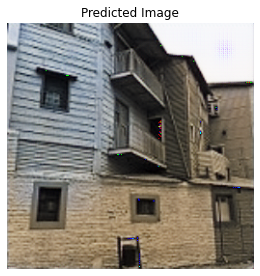

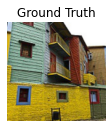

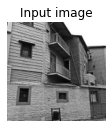

100%|██████████| 100/100 [00:10<00:00,  9.43it/s]


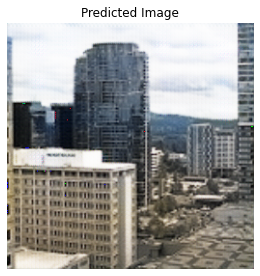

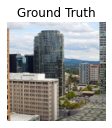

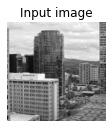

100%|██████████| 100/100 [00:10<00:00,  9.43it/s]


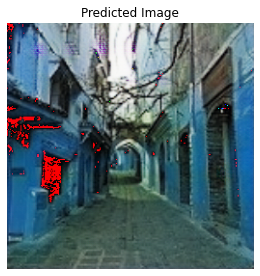

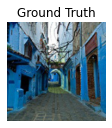

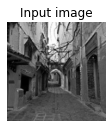

100%|██████████| 100/100 [00:10<00:00,  9.42it/s]


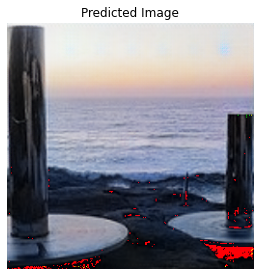

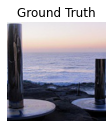

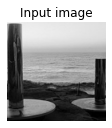

100%|██████████| 100/100 [00:10<00:00,  9.42it/s]


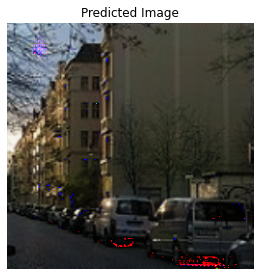

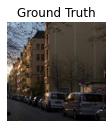

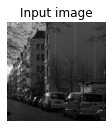

100%|██████████| 100/100 [00:10<00:00,  9.45it/s]


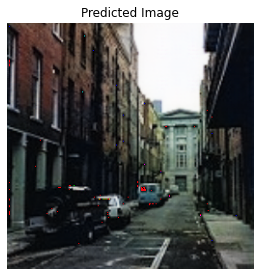

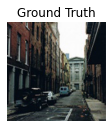

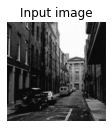

100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


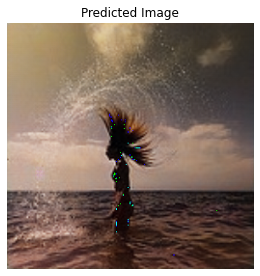

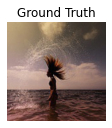

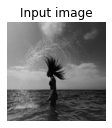

100%|██████████| 100/100 [00:10<00:00,  9.43it/s]


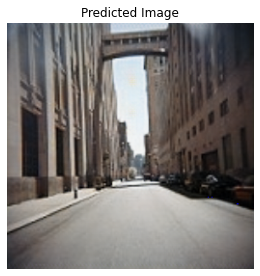

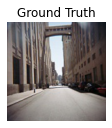

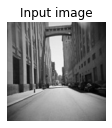

100%|██████████| 100/100 [00:10<00:00,  9.47it/s]


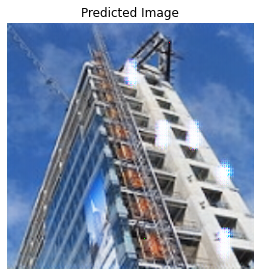

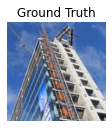

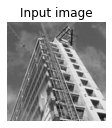

100%|██████████| 100/100 [00:10<00:00,  9.41it/s]


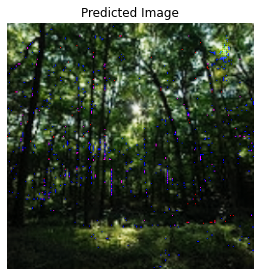

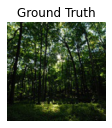

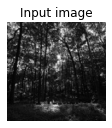

100%|██████████| 100/100 [00:10<00:00,  9.43it/s]


In [21]:
for i in range(N_EPOCH):
    train_loop(dataloader, disc, gen, opt_disc, opt_gen, mse, l1_loss)#Beginning of training
    gray, color = next(iter(dataloader))#Fetching some data from dataset
    gray = torch.tensor(gray, dtype=torch.float32)#Casting image to tensor
    color = torch.tensor(color, dtype=torch.float32)#Casting image to tensor
    gray = gray.to(DEVICE)
    color = color.to(DEVICE)
    if i % 50 == 0:
        generate_images(gen, gray, color)#Helper function to display images